## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization, Activation, Dropout

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], \
              l1_ratio=1e-4, l2_ratio=1e-4, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 10
MOMENTUM = 0.95
BATCH_SIZE = [16, 32]
Dropout_EXP = [0.1, 0.2]
LAYER_NEURONS = [[128, 128, 256], [128, 256, 512]]

In [7]:
import itertools

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (layer_neurons, drp_rate, bz) in enumerate(itertools.product(LAYER_NEURONS, Dropout_EXP, BATCH_SIZE)):
    print("Experiment with batch_size = %s, layer: %s, dropout_rate: %.2f" % (bz, layer_neurons, drp_rate))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drp_rate, num_neurons=layer_neurons)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(
                x_train, y_train, 
                epochs=EPOCHS, 
                batch_size=bz, 
                validation_data=(x_test, y_test), 
                shuffle=True,
                verbose=1
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s-layer-%s-drp-%2f-batch-%s" % (i, str(layer_neurons), drp_rate, bz)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with batch_size = 16, layer: [128, 128, 256], dropout_rate: 0.10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 22s 443us/step - loss: 3.1238 - accuracy: 0.2943 - val_loss: 2.7626 - val_accuracy: 0.3645
Epoch 2/10
50000/50000 [==============================] - 22s 445us/step - loss: 2.7690 - accuracy: 0.3284 - val_loss: 2.6580 - val_accuracy: 0.3280
Epoch 3/10
50000/50000 [==============================] - 22s 441us/step - loss: 2.5646 - accuracy: 0.3317 - val_loss: 2.4827 - val_accuracy: 0.3240
Epoch 4/10
50000/50000 [==============================] - 22s 437us/step - loss: 2.4240 - accuracy: 0.3234 - val_loss: 2.3111 - val_accuracy: 0.3472
Epoch 5/10
50000/50000 [==============================] - 22s 431us/step - loss: 2.3187 - accuracy: 0.3147 - val_loss: 2.0948 - val_accuracy: 0.3809
Epoch 6/10
50000/50000 [==============================] - 22s 433us/step - loss: 2.2174 - accuracy: 0.3170 - val_loss: 2.0329 - val_accuracy: 0.3822
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 24s 480us/step - loss: 2.0619 - accuracy: 0.3992 - val_loss: 2.3086 - val_accuracy: 0.3523
Epoch 10/10
50000/50000 [==============================] - 23s 461us/step - loss: 2.0288 - accuracy: 0.4003 - val_loss: 1.9714 - val_accuracy: 0.4155
Experiment with batch_size = 32, layer: [128, 256, 512], dropout_rate: 0.10
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 15s 308us/step - loss: 3.6302 - accuracy: 0.3112 - val_loss: 3.2465 - val_accuracy: 0.3928
Epoch 2/10
50000/50000 [==============================] - 14s 278us/step - loss: 3.2339 - accuracy: 0.3736 - val_loss: 2.9771 - val_accuracy: 0.4417
Epoch 3/10
50000/50000 [==============================] - 14s 278us/step - loss: 3.0316 - accuracy: 0.3899 - val_loss: 2.8212 - val_accuracy: 0.4417
Epoch 4/10
50000/50000 [==============================] - 14s 286us/step - loss: 2.8787 - accuracy: 0.3937 - val_loss: 2.6775 - val_accuracy: 0.4445
Epoch 5/10
50000/50000 [==============================] - 13s 268us/step - loss: 2.7556 - accuracy: 0.3880 - val_loss: 2.6563 - val_accuracy: 0.3998
Epoch 6/10
50000/50000 [==============================] - 13s 266us/step - loss: 2.6304 - accuracy: 0.3925 - val_loss: 2.5242 - val_accuracy: 0.4078
Epoch 7/10
50000/50000 [==============================] 

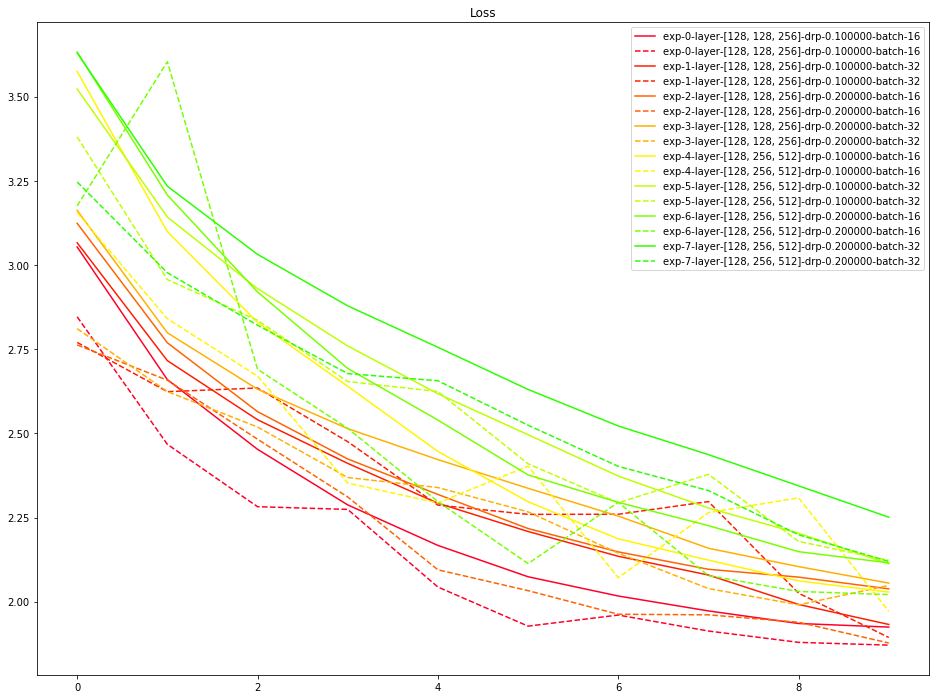

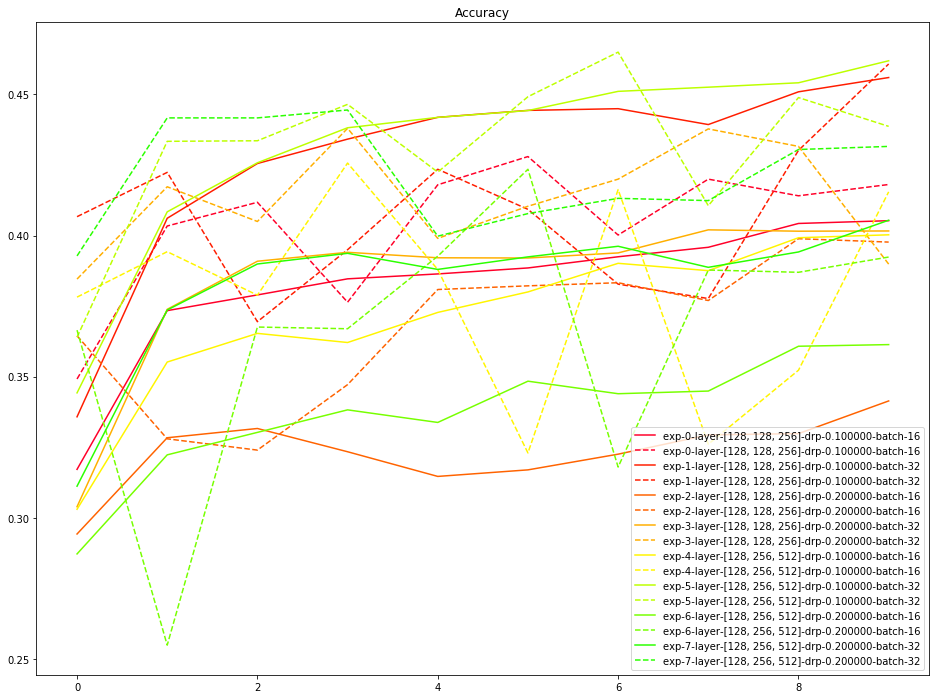

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
"""Code Here
將結果繪出
"""
plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,12))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()